In [4]:
import mwu_measures
import pandas as pd
import statsmodels.api as sm
from patsy import dmatrices
import numpy as np

First, you need to run the corpus processing function. Before trying other data, we can use the (hard-coded) synthetic corpus in Gries.

In [6]:
mwu_measures.process_corpus(test_corpus=True)

This is what a preprocess corpus should look like.

In [7]:
mwu_measures.processing_corpus.UNIGRAM_FREQUENCIES_PC

{'A': FreqDist({'a': 5, 'b': 5, 'c': 4, 'z': 2, 'n': 2, 'q': 2, 'r': 2, 'd': 1, 'e': 1, 'f': 1, ...}),
 'B': FreqDist({'b': 5, 'd': 4, 'x': 3, 'y': 2, 'c': 2, 'p': 2, 'e': 2, 'j': 2, 'q': 2, 'z': 2, ...}),
 'C': FreqDist({'g': 5, 'j': 4, 'k': 4, 'r': 3, 'b': 3, 'd': 3, 'h': 3, 'o': 2, 'c': 2, 'f': 2, ...})}

In [8]:
mwu_measures.processing_corpus.BIGRAM_PER_CORPUS

{'A': FreqDist({('c', 'b'): 3, ('a', 'd'): 1, ('d', 'c'): 1, ('b', 'e'): 1, ('e', 'b'): 1, ('b', 'f'): 1, ('f', 'g'): 1, ('g', 'h'): 1, ('h', 'c'): 1, ('b', 'i'): 1, ...}),
 'B': FreqDist({('b', 'd'): 3, ('y', 'i'): 1, ('i', 'b'): 1, ('b', 'c'): 1, ('c', 'p'): 1, ('p', 'x'): 1, ('x', 'e'): 1, ('e', 'j'): 1, ('j', 'd'): 1, ('d', 'g'): 1, ...}),
 'C': FreqDist({('d', 'g'): 2, ('h', 'k'): 2, ('g', 'g'): 1, ('g', 'i'): 1, ('i', 'o'): 1, ('o', 'r'): 1, ('r', 'j'): 1, ('j', 'j'): 1, ('j', 'b'): 1, ('b', 'c'): 1, ...})}

We can then easily compare the results from Gries' paper. These are the bigrams in tables 3 and 4. Note that entropy_2 in table 4 uses a different calculation, and is not supposed to match with the paper.
Also, because the author reports 1 - dispersion, I'll print it like that.

In [9]:
x = mwu_measures.get_mwu_scores(['b d', 'c b', 'a c'])
x['dispersion'] = 1 - x['dispersion']
x

,ngram,first,second,token_freq,dispersion,type_1,type_2,entropy_1,entropy_2,assoc_f,assoc_b
0,b d,b,d,3,0.199126,6,9,0.069372,0.029215,0.144810,0.243436
1,c b,c,b,5,0.811873,8,4,0.095055,0.225603,0.620430,0.404903
2,a c,a,c,2,0.565102,6,4,0.002592,0.039036,0.316464,0.239136


Now we can use real data and a real corpus. I used the BNC corpus because it's what I have at hand. This is currently the only corpus supported, but I'll add others soon. You have to get your own copy of the BNC.

In [ ]:
mwu_measures.process_corpus('bnc', 'bnc_tokenized.txt', chunk_size=100000, verbose=False)

We can take the multiword units from Muraki et al., 2022 (provided in the directory), from here: https://osf.io/ksypa/. For now, we can only use the bigrams. All bigrams not occurring in the BNC will be skipped.

In [7]:
mwu_examples = pd.read_csv('MultiwordExpression_Concreteness_Ratings.csv')
mwu_examples['length'] = mwu_examples['Expression'].apply(lambda x: len(x.split()))
mwu_examples = mwu_examples.loc[mwu_examples['length'] == 2]
mwu_examples['Expression'] = mwu_examples['Expression'].apply(lambda x: x.lower())
print(f'Number of possible bigrams: {len(mwu_examples)}')


Number of possible bigrams: 47486


In [ ]:
mwu_scores = mwu_measures.get_mwu_scores(mwu_examples['Expression'], normalize=True, entropy_limits=[-0.1, 0.1], scale_entropy=True, verbose=False, track_progress=True)
# TODO: this could very easily be parallel https://dask.pydata.org/en/latest/
# TODO: https://superfastpython.com/learning-paths/

1000 ngrams processed
2000 ngrams processed
3000 ngrams processed
4000 ngrams processed
5000 ngrams processed
6000 ngrams processed
7000 ngrams processed
8000 ngrams processed
9000 ngrams processed
10000 ngrams processed
11000 ngrams processed
12000 ngrams processed
13000 ngrams processed
14000 ngrams processed
15000 ngrams processed
16000 ngrams processed
17000 ngrams processed
18000 ngrams processed
19000 ngrams processed
20000 ngrams processed
21000 ngrams processed
22000 ngrams processed
23000 ngrams processed
24000 ngrams processed
25000 ngrams processed
26000 ngrams processed
27000 ngrams processed
28000 ngrams processed
29000 ngrams processed
30000 ngrams processed
31000 ngrams processed
32000 ngrams processed
33000 ngrams processed
34000 ngrams processed
35000 ngrams processed
36000 ngrams processed
37000 ngrams processed
38000 ngrams processed
39000 ngrams processed
40000 ngrams processed
41000 ngrams processed
42000 ngrams processed
43000 ngrams processed
44000 ngrams process

On my test computer, this took around 6 minutes, including the normalization step. In my laptop, it was more like 15. We can see how many we had to skip because they're not in the corpus.

In [20]:
print(f'Ngrams that occur in BNC: {len(mwu_scores['normalized'])}')

Ngrams that occur in BNC: 32588


Let's do something very sloppy just as an illustration: relationship between concreteness and the MWU measures?

In [21]:
mwu_examples_filter = mwu_examples.loc[mwu_examples['Expression'].isin(list(mwu_scores['normalized']['ngram']))]
concreteness_mwu = pd.merge(mwu_examples_filter, mwu_scores['normalized'], how='left', left_on='Expression', right_on='ngram')


In [22]:
concreteness_mwu = concreteness_mwu.dropna()

In [23]:

y, X = dmatrices('Mean_C ~ token_freq + dispersion + type_1 + type_2 + entropy_1 + entropy_2 + assoc_f + assoc_b', data=concreteness_mwu, return_type='dataframe')
mod = sm.OLS(y, X)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 Mean_C   R-squared:                       0.177
Model:                            OLS   Adj. R-squared:                  0.177
Method:                 Least Squares   F-statistic:                     846.3
Date:                Mon, 11 Nov 2024   Prob (F-statistic):               0.00
Time:                        23:40:27   Log-Likelihood:                -38588.
No. Observations:               31551   AIC:                         7.719e+04
Df Residuals:                   31542   BIC:                         7.727e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.3158      0.066     20.048      0.0

Nice! We can also take an MWU score based on this. First we can take an average, and compare it with a weighted average. This will be part of the package shortly.

In [24]:
only_scores = concreteness_mwu[['token_freq', 'dispersion', 'type_1', 'type_2', 'entropy_1', 'entropy_2', 'assoc_f', 'assoc_b']]
concreteness_mwu['mwu_score'] = only_scores.mean(axis = 1)

In [25]:
concreteness_mwu['mwu_weighted_1'] = only_scores.apply(lambda x: np.average(x, weights=[0.2, 0.2, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]), axis=1)
concreteness_mwu['mwu_weighted_2'] = only_scores.apply(lambda x: np.average(x, weights=[0.1, 0.3, 0.05, 0.05, 0.2, 0.2, 0.05, 0.05]), axis=1)

In [27]:
import seaborn as sns

<Axes: xlabel='mwu_score', ylabel='Mean_C'>

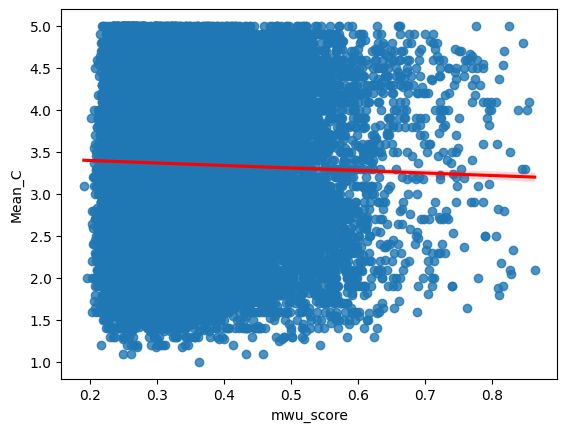

In [28]:
sns.regplot(x="mwu_score", y="Mean_C", data=concreteness_mwu, line_kws={"color": "red"})

<Axes: xlabel='mwu_weighted_1', ylabel='Mean_C'>

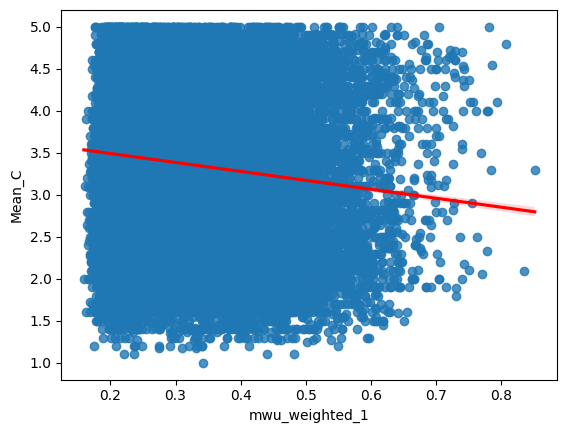

In [29]:
sns.regplot(x="mwu_weighted_1", y="Mean_C", data=concreteness_mwu, line_kws={"color": "red"})

<Axes: xlabel='mwu_weighted_2', ylabel='Mean_C'>

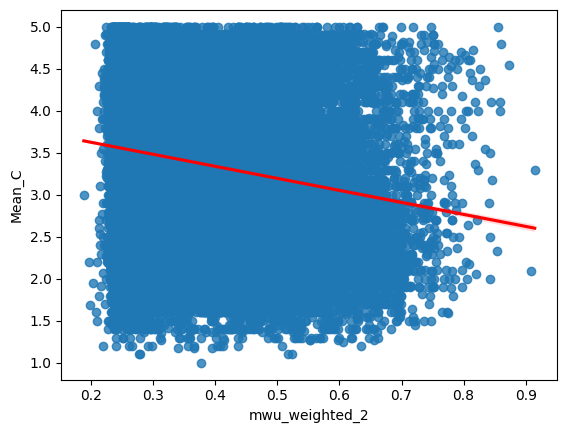

In [30]:
sns.regplot(x="mwu_weighted_2", y="Mean_C", data=concreteness_mwu, line_kws={"color": "red"})

Not the most interesting relationship, but it's a living. There you go!